# 자전거 스테이션 최적 위치 선정

## Station 최대 300개

## Station 별 자전거 거치대 최대 30대

In [2]:
import pathlib
import random
from functools import reduce
from collections import defaultdict

import pandas as pd
import geopandas as gpd
import folium
import shapely
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xgboost
import sklearn.cluster
import tensorflow as tf

from geoband import API

/opt/app-root/lib/python3.6/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [41]:
input_path = pathlib.Path('./input')
if not input_path.is_dir():
    input_path.mkdir()

API.GetCompasData('SBJ_2007_001', '1', input_path.joinpath('운영이력.csv'))
API.GetCompasData('SBJ_2007_001', '2', input_path.joinpath('자전거스테이션.csv'))
API.GetCompasData('SBJ_2007_001', '3', input_path.joinpath('꽃박람회일정.csv'))
API.GetCompasData('SBJ_2007_001', '4', input_path.joinpath('KINTEX행사일정.csv'))
API.GetCompasData('SBJ_2007_001', '5', input_path.joinpath('기상정보.csv'))
API.GetCompasData('SBJ_2007_001', '6', input_path.joinpath('인구(거주)분포도(100M_X_100M).geojson'))
API.GetCompasData('SBJ_2007_001', '7', input_path.joinpath('인구통계.csv'))
API.GetCompasData('SBJ_2007_001', '8', input_path.joinpath('행정경계(시군구).geojson'))
API.GetCompasData('SBJ_2007_001', '9', input_path.joinpath('행정경계(읍면동).geojson'))
API.GetCompasData('SBJ_2007_001', '10', input_path.joinpath('도시계획(공간시설).geojson'))
API.GetCompasData('SBJ_2007_001', '11', input_path.joinpath('도시계획(공공문화체육시설).geojson'))
API.GetCompasData('SBJ_2007_001', '12', input_path.joinpath('도시계획(교통시설).geojson'))
API.GetCompasData('SBJ_2007_001', '13', input_path.joinpath('용도지역지구(습지보호구역).geojson'))
API.GetCompasData('SBJ_2007_001', '14', input_path.joinpath('고양시 지적도.csv'))
API.GetCompasData('SBJ_2007_001', '15', input_path.joinpath('도로명주소_건물.geojson'))
API.GetCompasData('SBJ_2007_001', '16', input_path.joinpath('도로명주소_도로.geojson'))
API.GetCompasData('SBJ_2007_001', '17', input_path.joinpath('일반건물 분포도(100M X 100M).geojson'))
API.GetCompasData('SBJ_2007_001', '18', input_path.joinpath('행사장_공간정보.csv'))
API.GetCompasData('SBJ_2007_001', '19', input_path.joinpath('전철역_공간정보.csv'))
API.GetCompasData('SBJ_2007_001', '20', input_path.joinpath('고양시 버스정류소.csv'))
API.GetCompasData('SBJ_2007_001', '21', input_path.joinpath('버스_정류장별_승하차_정보.csv'))
API.GetCompasData('SBJ_2007_001', '22', input_path.joinpath('주차장정보.csv'))
API.GetCompasData('SBJ_2007_001', '23', input_path.joinpath('고양시덕양구_DEM.img'))
API.GetCompasData('SBJ_2007_001', '24', input_path.joinpath('고양시일산동구_DEM.img'))
API.GetCompasData('SBJ_2007_001', '25', input_path.joinpath('고양시일산서구_DEM.img'))
API.GetCompasData('SBJ_2007_001', '26', input_path.joinpath('고양시_공연장_박물관_정보.csv'))
API.GetCompasData('SBJ_2007_001', '27', input_path.joinpath('고양시_체육시설_현황_정보.csv'))
API.GetCompasData('SBJ_2007_001', '28', input_path.joinpath('코드정의서.xlsx'))
API.GetCompasData('SBJ_2007_001', '29', input_path.joinpath('지하철 역별 이용객수.csv'))

for path in list(input_path.glob('*.*')):
    print(path)

input/운영이력.csv
input/자전거스테이션.csv
input/일반건물 분포도(100M X 100M).geojson
input/도로명주소_건물.geojson
input/도로명주소_도로.geojson
input/전철역_공간정보.csv
input/고양시 버스정류소.csv
input/꽃박람회일정.csv
input/KINTEX행사일정.csv
input/기상정보.csv
input/인구(거주) 분포도(100M X 100M).geojson
input/인구통계.csv
input/행정통계(시군구).csv
input/행정통계(읍면동).csv
input/도시계획(공간시설).csv
input/도시계획(공공문화체육시설).csv
input/도시계획(교통시설).csv
input/용도지역지구(습지보호구역).csv
input/고양시 지적도.csv
input/행사장_공간정보.csv
input/용도지역지구(습지보호구역).geojson
input/고양시일산동구_DEM.img
input/버스_정류장별_승하차_정보.csv
input/주차장정보.csv
input/고양시덕양구_DEM.img
input/고양시일산서구_DEM.img
input/고양시_공연장_박물관_정보.csv
input/고양시_체육시설_현황_정보.csv
input/코드정의서.xlsx
input/지하철 역별 이용객수.csv
input/인구(거주)분포도(100M X 100M).geojson
input/행정경계(시군구).csv
input/인구(거주)분포도(100M_X_100M).geojson
input/행정경계(읍면동).csv
input/행정경계(시군구).geojson
input/행정경계(읍면동).geojson
input/도시계획(공간시설).geojson
input/도시계획(공공문화체육시설).geojson
input/도시계획(교통시설).geojson


In [4]:
기상정보 = pd.read_csv(input_path.joinpath('기상정보.csv'))

In [5]:
기상정보

,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),일강수량(mm),최대 순간 풍속(m/s),최대 순간풍속 시각(hhmi),평균 풍속(m/s),최대 순간 풍속 풍향(deg)
0,2017-01-01,2.7,-3.2,544.0,8.4,1411.0,0.0,4.1,1232.0,0.4,185.6
1,2017-01-02,5.4,0.4,2359.0,10.2,1402.0,0.0,7.3,1504.0,1.6,309.4
2,2017-01-03,0.5,-4.8,736.0,7.7,1347.0,0.0,5.1,1452.0,0.7,309.4
3,2017-01-04,2.0,-2.6,2339.0,9.4,1455.0,0.0,5.3,1506.0,0.7,323.4
4,2017-01-05,2.8,-3.2,317.0,8.5,1422.0,0.0,6.2,1548.0,0.6,109.7
...,...,...,...,...,...,...,...,...,...,...,...
1085,2019-12-27,-2.4,-7.4,745.0,3.2,1410.0,0.0,6.7,1608.0,1.1,326.3
1086,2019-12-28,1.2,-5.3,114.0,6.7,1333.0,0.0,6.0,1030.0,1.2,177.2
1087,2019-12-29,4.1,-0.2,442.0,7.5,1524.0,0.0,5.2,1142.0,0.8,191.3
1088,2019-12-30,2.0,-6.2,2357.0,6.9,1043.0,0.5,10.2,2237.0,1.9,331.9


기상정보는 좀 쓸데없어 보이네

In [6]:
인구통계 = pd.read_csv(input_path.joinpath('인구통계.csv'))

In [7]:
인구통계

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
0,경기도 고양시 (4128000000),2017년01월,"1,040,648","402,440",2.59,"511,353","529,295",0.97
1,경기도 고양시 (4128000000),2017년02월,"1,040,483","403,042",2.58,"511,266","529,217",0.97
2,경기도 고양시 (4128000000),2017년03월,"1,040,482","403,443",2.58,"511,182","529,300",0.97
3,경기도 고양시 (4128000000),2017년04월,"1,040,608","403,933",2.58,"511,225","529,383",0.97
4,경기도 고양시 (4128000000),2017년05월,"1,040,892","404,603",2.57,"511,347","529,545",0.97
...,...,...,...,...,...,...,...,...
1579,경기도 고양시 일산서구 송산동(4128759000),2019년08월,"50,610","18,390",2.75,"24,983","25,627",0.97
1580,경기도 고양시 일산서구 송산동(4128759000),2019년09월,"50,694","18,404",2.75,"25,025","25,669",0.97
1581,경기도 고양시 일산서구 송산동(4128759000),2019년10월,"50,660","18,398",2.75,"25,020","25,640",0.98
1582,경기도 고양시 일산서구 송산동(4128759000),2019년11월,"50,865","18,480",2.75,"25,112","25,753",0.98


In [8]:
1584/24

66.0

In [9]:
인구통계['행정구역'].unique()

array(['경기도 고양시 (4128000000)', '경기도 고양시 덕양구 (4128100000)',
       '경기도 고양시 덕양구 주교동(4128151000)', '경기도 고양시 덕양구 원신동(4128152000)',
       '경기도 고양시 덕양구 흥도동(4128153000)', '경기도 고양시 덕양구 성사1동(4128154000)',
       '경기도 고양시 덕양구 성사2동(4128155000)', '경기도 고양시 덕양구 효자동(4128156000)',
       '경기도 고양시 덕양구 신도동(4128157000)', '경기도 고양시 덕양구 삼송동(4128157500)',
       '경기도 고양시 덕양구 창릉동(4128158000)', '경기도 고양시 덕양구 고양동(4128159000)',
       '경기도 고양시 덕양구 관산동(4128160000)', '경기도 고양시 덕양구 능곡동(4128161000)',
       '경기도 고양시 덕양구 화정1동(4128162100)', '경기도 고양시 덕양구 화정2동(4128162200)',
       '경기도 고양시 덕양구 행주동(4128163000)', '경기도 고양시 덕양구 행신1동(4128164000)',
       '경기도 고양시 덕양구 행신2동(4128165000)', '경기도 고양시 덕양구 행신3동(4128165500)',
       '경기도 고양시 덕양구 화전동(4128166000)', '경기도 고양시 덕양구 대덕동(4128167000)',
       '경기도 고양시 일산동구 (4128500000)', '경기도 고양시 일산동구 식사동(4128551000)',
       '경기도 고양시 일산동구 중산동(4128552000)', '경기도 고양시 일산동구 정발산동(4128553000)',
       '경기도 고양시 일산동구 풍산동(4128554000)', '경기도 고양시 일산동구 백석1동(4128555100)',
       '경기도 고양시 일산동구 백석2동(412855

## 아이디어

unique 데이터 수는 66개 - 구/시 (4개) =  총 62개를 활용할 수 있을듯

인구수도 2020년을 예측해서 해야하나?

In [10]:
습지보호구역 = gpd.read_file(input_path.joinpath('용도지역지구(습지보호구역).geojson'))

In [11]:
습지보호구역

,MNUM,ALIAS,REMARK,geometry
0,14800004128020060058UMQ1000000001,장항습지,장항습지,"MULTIPOLYGON (((126.68313 37.69578, 126.68341 ..."


In [12]:
습지보호구역['geometry']

0    MULTIPOLYGON (((126.68313 37.69578, 126.68341 ...
Name: geometry, dtype: geometry

In [13]:
습지보호구역.shape

(1, 4)

## 아이디어

근데 찾아보니까 장항습지 자전거길이 잘되어있나보다

심지어 고양에서 서울까지 뚫려있는듯

장항습지인접 지역에는 1, 아니면 0 이런식으로 데이터 추가해주면 좋을듯!

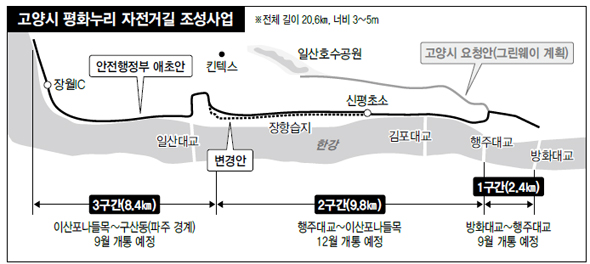

In [14]:
자전거스테이션 = pd.read_csv(input_path.joinpath('자전거스테이션.csv'))
자전거스테이션.describe(include='all')

,Station_ID,STATION_NAME,거치대 수량,위도,경도
count,164.000000,164,164.000000,164.000000,164.000000
unique,NaN,164,NaN,NaN,NaN
top,NaN,★일산 요진와이시티 공원,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN
mean,231.987805,NaN,26.189024,37.658544,126.799452
std,96.579919,NaN,7.087161,0.024517,0.043810
min,101.000000,NaN,4.000000,37.591856,126.717535
25%,161.750000,NaN,20.000000,37.643943,126.767998
50%,228.500000,NaN,25.000000,37.660869,126.785039
75%,306.250000,NaN,30.000000,37.675909,126.832985


In [18]:
자전거스테이션

,Station_ID,STATION_NAME,거치대 수량,위도,경도
0,101,어울림마을 701동 앞,20,37.654775,126.834584
1,103,대림e-편한세상106동,20,37.660442,126.840377
2,104,탄현마을8단지,25,37.698523,126.766042
3,105,KT 덕양지사 앞,20,37.655244,126.839261
4,106,원당역 앞 공영주차장,30,37.653410,126.842530
...,...,...,...,...,...
159,350,★하이파크5단지 502동앞 버스정류장,20,37.697867,126.753089
160,351,◆일산에듀포레 푸르지오,40,37.702259,126.767231
161,352,◆꿈에그린203동앞,40,37.666425,126.749244
162,353,◆꿈에그린106동앞,40,37.666720,126.750784


## 아이디어 


기존 이용 내역을 보면 거치대 수량이 많은 곳과 적은 곳을 알 수 있는데, 이때 위치적 특성을 생각해보자 (위도, 경도와 건물 용도를 엮으면.. 할수있지않을까?)

예를 들어, 꿈에그린 203동 앞엔 40대나 있는데 1.주거지역 2. 송포동 ...

특별히 송포동 아파트 단지 내에 거치대 수가 많네 


In [16]:
전철역 = pd.read_csv(input_path.joinpath('전철역_공간정보.csv'))
전철역

,rail_nm,station_nm,lot_num_addr,road_nm_addr,X,Y
0,3호선,대곡,경기도 고양시 덕양구 대장동 420-1,경기도 고양시 덕양구 대주로107번길 71-81,126.809614,37.632306
1,3호선,대화,경기도 고양시 일산서구 대화동 2221,경기도 고양시 일산서구 중앙로 지하 1569,126.747206,37.675846
2,경의중앙,일산,경기도 고양시 일산서구 일산동 655-691,경기도 고양시 일산서구 경의로 672,126.770067,37.682007
3,3호선,백석,경기도 고양시 일산동구 백석동 1538,경기도 고양시 일산동구 중앙로 지하 1042,126.788148,37.642953
4,경의중앙,대곡,경기도 고양시 덕양구 대장동 420-1,경기도 고양시 덕양구 대주로 107번길 71-81,126.811047,37.631615
5,경의중앙,강매,경기도 고양시 덕양구 행신동 1115-1,경기도 고양시 덕양구 소원로 202,126.844436,37.612290
6,경의중앙,백마,경기도 고양시 일산동구 백석동 92,경기도 고양시 일산동구 경의로 318,126.794067,37.658431
7,경의중앙,능곡,경기도 고양시 덕양구 토당동 454-3,경기도 고양시 덕양구 토당로 35,126.820838,37.618765
8,경의중앙,풍산,경기도 고양시 일산동구 풍동 1042,경기도 고양시 일산동구 경의로 486,126.786528,37.671815
9,경의중앙,행신,경기도 고양시 덕양구 행신동 812,경기도 고양시 덕양구 소원로 114,126.834117,37.612170


In [17]:
버스정류소 = pd.read_csv(input_path.joinpath('고양시 버스정류소.csv'))
버스정류소

,STATION_NM,STATION_ID,X,Y
0,신일비즈니스고등학교,219000619,126.760592,37.683296
1,중앙공원삼거리,219000587,126.776989,37.688934
2,문촌마을14.19단지,219000624,126.752451,37.671011
3,문촌마을14.19단지,219000623,126.752452,37.671448
4,중앙공원삼거리,219000586,126.777412,37.688771
...,...,...,...,...
2227,고양시청후문,218000940,126.832676,37.659090
2228,사리현동문아파트,219000927,126.845347,37.699382
2229,서울시립고양병원입구,218000530,126.852005,37.712236
2230,옥빛마을14.15단지,218001000,126.833325,37.628699


In [20]:
도로명주소_건물 = gpd.read_file(input_path.joinpath('도로명주소_건물.geojson'))
도로명주소_건물['BDTYP_CD']

0        01003
1        02003
2        02003
3        03999
4        03005
         ...  
79997    03012
79998    21999
79999    03001
80000    01003
80001    01001
Name: BDTYP_CD, Length: 80002, dtype: object

BDTYP_CD : 건물 용도 코드

EMD_CD : 읍면동 코드

In [26]:
인구분포도 = gpd.read_file(input_path.joinpath('인구(거주)분포도(100M_X_100M).geojson'))
인구분포도

,gid,val,geometry
0,다사268650,NaN,"MULTIPOLYGON (((126.66985 37.68162, 126.66984 ..."
1,다사268651,NaN,"MULTIPOLYGON (((126.66984 37.68252, 126.66983 ..."
2,다사268652,NaN,"MULTIPOLYGON (((126.66983 37.68342, 126.66982 ..."
3,다사268653,NaN,"MULTIPOLYGON (((126.66982 37.68432, 126.66981 ..."
4,다사268654,NaN,"MULTIPOLYGON (((126.66981 37.68522, 126.66980 ..."
...,...,...,...
27345,다사553641,NaN,"MULTIPOLYGON (((126.99310 37.67534, 126.99310 ..."
27346,다사553642,NaN,"MULTIPOLYGON (((126.99310 37.67624, 126.99309 ..."
27347,다사553643,NaN,"MULTIPOLYGON (((126.99309 37.67714, 126.99308 ..."
27348,다사553644,NaN,"MULTIPOLYGON (((126.99308 37.67804, 126.99308 ..."


In [28]:
운영이력 = pd.read_csv(input_path.joinpath('운영이력.csv'))
for column in ['LEAS_NO', 'LEAS_STATION', 'LEAS_DEF_NO', 'RTN_STATION', 'RTN_DEF_NO', 'MEMB_NO', 'TEMP_MEMB_NO']:
    운영이력[column] = 운영이력[column].apply(str)
    
운영이력.describe(include='all')
운영이력['LEAS_DATE_ONLY'] = 운영이력['LEAS_DATE'].apply(lambda x: x.split(' ')[0])
운영이력['LEAS_DATE_ONLY']

/opt/app-root/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0          2017-01-01
1          2017-01-01
2          2017-01-01
3          2017-01-01
4          2017-01-01
              ...    
3142683    2019-12-31
3142684    2019-12-31
3142685    2019-12-31
3142686    2019-12-31
3142687    2019-12-31
Name: LEAS_DATE_ONLY, Length: 3142688, dtype: object

In [29]:
최대대여량 = 운영이력.groupby(['LEAS_DATE_ONLY', 'LEAS_STATION']).count().max(axis=1).reset_index().groupby('LEAS_STATION')[0].max()
최대대여량

LEAS_STATION
101    27
103    19
104    36
105    15
106    16
       ..
349    28
350    23
351    60
992     9
998    16
Name: 0, Length: 156, dtype: int64

In [30]:
최대반납량 = 운영이력.groupby(['LEAS_DATE_ONLY', 'RTN_STATION']).count().max(axis=1).reset_index().groupby('RTN_STATION')[0].max()
최대반납량

RTN_STATION
0      1600
101      27
103      25
104      30
105      12
       ... 
350      22
351      31
992       9
998      15
999       1
Name: 0, Length: 158, dtype: int64

In [34]:
운영이력['TRNV_QTY']

0              0.0
1          31039.0
2              NaN
3          15490.0
4              0.0
            ...   
3142683        0.0
3142684        0.0
3142685        0.0
3142686        0.0
3142687    33169.0
Name: TRNV_QTY, Length: 3142688, dtype: float64

## 아이디어

### 2017년 부터 2019년 까지의 운영이력

활용할 수 있는 정보 

1. 어느 스테이션은 얼마나 이용량이 많은가 
1. 한 스테이션에서의 이동 범위 조사 ==> **대충 한 스테이션의 커버 범위를 정하는데 도움이 될듯**


In [39]:
행정경계 = gpd.read_file(input_path.joinpath('행정경계(읍면동).geojson'))
행정경계

,EMD_CD,EMD_KOR_NM,geometry
0,41281101,주교동,"MULTIPOLYGON (((126.81068 37.65820, 126.81069 ..."
1,41281102,원당동,"MULTIPOLYGON (((126.83321 37.68013, 126.83340 ..."
2,41281103,신원동,"MULTIPOLYGON (((126.86362 37.67729, 126.86364 ..."
3,41281104,원흥동,"MULTIPOLYGON (((126.85975 37.65081, 126.85990 ..."
4,41281105,도내동,"MULTIPOLYGON (((126.84806 37.62348, 126.84835 ..."
5,41281106,성사동,"MULTIPOLYGON (((126.83047 37.64860, 126.83053 ..."
6,41281107,북한동,"MULTIPOLYGON (((126.95320 37.65582, 126.95334 ..."
7,41281108,효자동,"MULTIPOLYGON (((126.94756 37.65922, 126.94777 ..."
8,41281109,지축동,"MULTIPOLYGON (((126.89619 37.65389, 126.89627 ..."
9,41281110,오금동,"MULTIPOLYGON (((126.89197 37.67066, 126.89222 ..."


엥 동 62개인 줄 알았는데 왜 52개지???

In [43]:
도시계획_공간시설 = gpd.read_file(input_path.joinpath('도시계획(공간시설).geojson'))
도시계획_공간시설

,MNUM,ALIAS,REMARK,geometry
0,39400004128020200102UQT3300001000,None,None,"MULTIPOLYGON (((126.79244 37.67061, 126.79245 ..."
1,39400004128020200102UQT3300002000,None,None,"MULTIPOLYGON (((126.79125 37.66747, 126.79126 ..."
2,39400004128020200102UQT2100001000,None,None,"MULTIPOLYGON (((126.79216 37.67002, 126.79221 ..."
3,39400004128020200102UQT3100001000,None,None,"MULTIPOLYGON (((126.79275 37.66799, 126.79301 ..."
4,39400004128020200102UQT3100002000,None,None,"MULTIPOLYGON (((126.79139 37.66740, 126.79154 ..."
...,...,...,...,...
1089,16130004128020130925UQT3200087000,None,None,"MULTIPOLYGON (((126.87392 37.64883, 126.87388 ..."
1090,16130004128020150203UQT2200005000,None,None,"MULTIPOLYGON (((126.88345 37.66780, 126.88346 ..."
1091,16130004128020150203UQT2200003000,None,None,"MULTIPOLYGON (((126.88881 37.64833, 126.88854 ..."
1092,16130004128020150203UQT2200002000,None,None,"MULTIPOLYGON (((126.88267 37.64497, 126.88218 ..."


In [44]:
도시계획_공간시설['MNUM'].unique()

array(['39400004128020200102UQT3300001000',
       '39400004128020200102UQT3300002000',
       '39400004128020200102UQT2100001000', ...,
       '16130004128020150203UQT2200003000',
       '16130004128020150203UQT2200002000',
       '39400004128020200102UQT2600002000'], dtype=object)

현재 기준의 고양시 도시계획(공간시설, 공원, 녹지 등) 정보입니다.

* MNUM    공간시설 관리번호 입니다.

* ALIAS    공간시설 별칭 입니다.

* REMARK    공간시설에 관한 비고 입니다.

공원이랑 녹지 이런거 어딨는지 알고 싶긴한데.. 어디가 어딘지요...

geometry로 이용해야하나.. 

공원이랑 녹지에 인접해있는 지 정도를 알고 싶음

## 아이디어

최대 이용량 K-means cluster로 하되, 너무 범위가 커지는 경우 (최대이용량 높은데 범위가 커지는 경우는) 기준을 세워서 스테이션을 비례해서 많이 두게 하면 어떰? 

한 스테이션 당 범위를 구해서 (운영이력 데이터로)... 그 범위 이상으로 커지면, 스테이션을 비례해서 몇개 더 두고 이런식??

In [45]:
주차장 = pd.read_csv(input_path.joinpath('주차장정보.csv'))
주차장

,parking_nm,road_nm_addr,lot_num_addr,space,X,Y
0,고양시청 부설주차장,경기도 고양시 덕양구 고양시청로10,경기도 고양시 덕양구 주교동 600,140,126.832072,37.658042
1,고양제1,경기도 고양시 덕양구 벽제관로 8,경기도 고양시 덕양구 고양동 195-2,94,126.903861,37.703783
2,고양제2,경기도 고양시 덕양구 혜음로 103,경기도 고양시 덕양구 고양동 444-1,31,126.905347,37.710213
3,노상 1권역,경기도 고양시 덕양구 고양시청로 10,경기도 고양시 덕양구 주교동 600,97,126.831960,37.658414
4,노상 3권역,경기도 고양시 덕양구 은빛로 39,경기도 고양시 덕양구 화정동 909,123,126.832173,37.638096
...,...,...,...,...,...,...
65,호수공원 부설주차장 2,경기도 고양시 일산동구 호수로 595,경기도 고양시 일산동구 장항동 906,512,126.763193,37.661923
66,호수공원 부설주차장 3,경기도 고양시 일산동구 호수로 595,경기도 고양시 일산동구 장항동 906,54,126.769069,37.654901
67,호수공원 부설주차장 4,경기도 고양시 일산동구 호수로 595,경기도 고양시 일산동구 장항동 906,125,126.770942,37.651669
68,화정환승,경기도 고양시 덕양구 화정로 지하 63,경기도 고양시 덕양구 화정동 963,253,126.833046,37.634951


## 아이디어

주차장 있는 곳은 이용량이 좀 떨어지지 않을까..???

차타고 못가면 자전거 많이 이용할 것 같기도 하고 ... 흠

주차장이 커버하는 범위를 생각해서 그 안에 들어오면 1,0 이런식으로 학습데이터에 피쳐를 늘리는 방식은 어떤가....


In [46]:
!pip install xlrd
!pip install openpyxl

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 241 kB 995 kB/s eta 0:00:01
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=1bde1c52efff5e5058792b15043e5e79e10d4da34eada6e3863262d654516682
  Stored in directory: /tmp/pip-ephem-wheel-cache-84o0p7gr/wheels/ef/92/e0/956c00decf3091294b8800d9104f6169a1adacfaafd122ed42
Successfully built et-xmlfile


In [47]:
코드번호 = pd.read_excel(input_path.joinpath('코드정의서.xlsx'))
코드번호

,Unnamed: 0,Unnamed: 1
0,읍면동 코드(EMD_CD),NaN
1,코드,코드명
2,41281101,경기도 고양시 덕양구 주교동
3,41281102,경기도 고양시 덕양구 원당동
4,41281103,경기도 고양시 덕양구 신원동
...,...,...
551,시군구 코드(SIG_CD),NaN
552,코드,코드명
553,41281,경기도 고양시 덕양구
554,41285,경기도 고양시 일산동구


이 코드 어따 쓰는거야? ???